In [1]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras import callbacks
import os
import cv2
import string
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt

#Init main values
# symbols = string.ascii_lowercase + "0123456789" # All symbols captcha can contain
symbols = "0123456789" # All symbols captcha can contain
num_symbols = len(symbols)
img_shape = (62, 175, 1)

In [2]:
print(num_symbols)

10


In [3]:
def create_model():
    img = layers.Input(shape=img_shape) # Get image as an input and process it through some Convs
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 100x25
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 50x13
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # 25x7
    
    # Get flattened vector and make 5 branches from it. Each branch will predict one letter
    flat = layers.Flatten()(mp3)
    outs = []
    #we have 6 letters
    for _ in range(6):
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        res = layers.Dense(num_symbols, activation='sigmoid')(drop)

        outs.append(res)
    
    # Compile model and return it
    model = Model(img, outs)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    return model

Importing Data

In [4]:
def preprocess_data():
    n_samples = len(os.listdir('data/wetax'))
    X = np.zeros((n_samples, 62, 175, 1)) #1070*62*175
    y = np.zeros((6, n_samples, num_symbols)) #6*1070*10

    for i, pic in enumerate(os.listdir('data/wetax')):
        # Read image as grayscale
        img = cv2.imread(os.path.join('data/wetax', pic), cv2.IMREAD_GRAYSCALE)
        pic_target = pic[:-4]
        if len(pic_target) < 7:
            # Scale and reshape image
            img = img / 255.0
            img = np.reshape(img, (62, 175, 1))
            # Define targets and code them using OneHotEncoding
            targs = np.zeros((6, num_symbols))
            for j, l in enumerate(pic_target):
                ind = symbols.find(l)
                targs[j, ind] = 1
            X[i] = img
            y[:, i] = targs
    
    # Return final data
    return X, y

X, y = preprocess_data()
X_train, y_train = X[:970], y[:, :970]
X_test, y_test = X[970:], y[:, 970:]
print(str(len(X_train)) + " training samples")
print(str(len(X_test)) + " validation samples")


970 training samples
134 validation samples


In [5]:
model=create_model();
model.summary();

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 62, 175, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 62, 175, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 31, 88, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 31, 88, 32)   4640        max_pooling2d[0][0]              
_______________________________________________________________________________________

In [6]:
#model = create_model()
hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4], y_train[5]], batch_size=32, epochs=200,verbose=1, validation_split=0.2)

Epoch 1/200
25/25 [==============================] - 1s 57ms/step - loss: 13.6066 - dense_1_loss: 2.0620 - dense_3_loss: 2.3083 - dense_5_loss: 2.3104 - dense_7_loss: 2.3088 - dense_9_loss: 2.3059 - dense_11_loss: 2.3112 - dense_1_accuracy: 0.2126 - dense_3_accuracy: 0.1456 - dense_5_accuracy: 0.1430 - dense_7_accuracy: 0.1173 - dense_9_accuracy: 0.1289 - dense_11_accuracy: 0.1186 - val_loss: 13.8465 - val_dense_1_loss: 2.3487 - val_dense_3_loss: 2.3001 - val_dense_5_loss: 2.2989 - val_dense_7_loss: 2.2993 - val_dense_9_loss: 2.3005 - val_dense_11_loss: 2.2990 - val_dense_1_accuracy: 0.0000e+00 - val_dense_3_accuracy: 0.0722 - val_dense_5_accuracy: 0.2010 - val_dense_7_accuracy: 0.1134 - val_dense_9_accuracy: 0.1289 - val_dense_11_accuracy: 0.1340
Epoch 2/200
25/25 [==============================] - 1s 27ms/step - loss: 12.0559 - dense_1_loss: 1.5105 - dense_3_loss: 2.0755 - dense_5_loss: 2.1262 - dense_7_loss: 2.1284 - dense_9_loss: 2.1482 - dense_11_loss: 2.0671 - dense_1_accuracy: 0

Epoch 12/200
25/25 [==============================] - 1s 25ms/step - loss: 2.3400 - dense_1_loss: 0.0783 - dense_3_loss: 0.3814 - dense_5_loss: 0.4326 - dense_7_loss: 0.4557 - dense_9_loss: 0.6744 - dense_11_loss: 0.3177 - dense_1_accuracy: 0.9755 - dense_3_accuracy: 0.8711 - dense_5_accuracy: 0.8595 - dense_7_accuracy: 0.8389 - dense_9_accuracy: 0.7732 - dense_11_accuracy: 0.9072 - val_loss: 9.9495 - val_dense_1_loss: 3.2677 - val_dense_3_loss: 1.2988 - val_dense_5_loss: 1.2671 - val_dense_7_loss: 1.4176 - val_dense_9_loss: 1.5511 - val_dense_11_loss: 1.1473 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9175 - val_dense_5_accuracy: 0.9381 - val_dense_7_accuracy: 0.8196 - val_dense_9_accuracy: 0.8711 - val_dense_11_accuracy: 0.8763
Epoch 13/200
25/25 [==============================] - 1s 25ms/step - loss: 2.0600 - dense_1_loss: 0.0636 - dense_3_loss: 0.2929 - dense_5_loss: 0.3718 - dense_7_loss: 0.4278 - dense_9_loss: 0.6456 - dense_11_loss: 0.2583 - dense_1_accuracy: 0.9832

Epoch 23/200
25/25 [==============================] - 1s 25ms/step - loss: 0.8671 - dense_1_loss: 0.0382 - dense_3_loss: 0.1238 - dense_5_loss: 0.1564 - dense_7_loss: 0.2106 - dense_9_loss: 0.2511 - dense_11_loss: 0.0870 - dense_1_accuracy: 0.9884 - dense_3_accuracy: 0.9613 - dense_5_accuracy: 0.9485 - dense_7_accuracy: 0.9317 - dense_9_accuracy: 0.9162 - dense_11_accuracy: 0.9639 - val_loss: 11.9815 - val_dense_1_loss: 11.3013 - val_dense_3_loss: 0.0753 - val_dense_5_loss: 0.0600 - val_dense_7_loss: 0.1961 - val_dense_9_loss: 0.2767 - val_dense_11_loss: 0.0720 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9794 - val_dense_5_accuracy: 0.9948 - val_dense_7_accuracy: 0.9227 - val_dense_9_accuracy: 0.9227 - val_dense_11_accuracy: 0.9742
Epoch 24/200
25/25 [==============================] - 1s 27ms/step - loss: 0.7556 - dense_1_loss: 0.0398 - dense_3_loss: 0.1377 - dense_5_loss: 0.1179 - dense_7_loss: 0.1654 - dense_9_loss: 0.2075 - dense_11_loss: 0.0873 - dense_1_accuracy: 0.99

Epoch 34/200
25/25 [==============================] - 1s 27ms/step - loss: 0.4894 - dense_1_loss: 0.0136 - dense_3_loss: 0.0713 - dense_5_loss: 0.0653 - dense_7_loss: 0.1158 - dense_9_loss: 0.1598 - dense_11_loss: 0.0636 - dense_1_accuracy: 0.9974 - dense_3_accuracy: 0.9768 - dense_5_accuracy: 0.9742 - dense_7_accuracy: 0.9613 - dense_9_accuracy: 0.9459 - dense_11_accuracy: 0.9781 - val_loss: 14.5787 - val_dense_1_loss: 13.9708 - val_dense_3_loss: 0.0742 - val_dense_5_loss: 0.0170 - val_dense_7_loss: 0.2353 - val_dense_9_loss: 0.2349 - val_dense_11_loss: 0.0466 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9897 - val_dense_5_accuracy: 0.9948 - val_dense_7_accuracy: 0.9433 - val_dense_9_accuracy: 0.9330 - val_dense_11_accuracy: 0.9897
Epoch 35/200
25/25 [==============================] - 1s 25ms/step - loss: 0.4923 - dense_1_loss: 0.0208 - dense_3_loss: 0.0757 - dense_5_loss: 0.0622 - dense_7_loss: 0.1157 - dense_9_loss: 0.1526 - dense_11_loss: 0.0653 - dense_1_accuracy: 0.99

Epoch 45/200
25/25 [==============================] - 1s 26ms/step - loss: 0.3612 - dense_1_loss: 0.0255 - dense_3_loss: 0.0481 - dense_5_loss: 0.0686 - dense_7_loss: 0.0846 - dense_9_loss: 0.0998 - dense_11_loss: 0.0346 - dense_1_accuracy: 0.9923 - dense_3_accuracy: 0.9832 - dense_5_accuracy: 0.9742 - dense_7_accuracy: 0.9716 - dense_9_accuracy: 0.9536 - dense_11_accuracy: 0.9871 - val_loss: 15.3889 - val_dense_1_loss: 14.7535 - val_dense_3_loss: 0.0949 - val_dense_5_loss: 0.0217 - val_dense_7_loss: 0.1732 - val_dense_9_loss: 0.3193 - val_dense_11_loss: 0.0263 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9897 - val_dense_5_accuracy: 0.9897 - val_dense_7_accuracy: 0.9639 - val_dense_9_accuracy: 0.9278 - val_dense_11_accuracy: 0.9897
Epoch 46/200
25/25 [==============================] - 1s 31ms/step - loss: 0.3805 - dense_1_loss: 0.0160 - dense_3_loss: 0.0648 - dense_5_loss: 0.0622 - dense_7_loss: 0.0895 - dense_9_loss: 0.0995 - dense_11_loss: 0.0485 - dense_1_accuracy: 0.99

Epoch 56/200
25/25 [==============================] - 1s 25ms/step - loss: 0.3450 - dense_1_loss: 0.0319 - dense_3_loss: 0.0415 - dense_5_loss: 0.0607 - dense_7_loss: 0.0643 - dense_9_loss: 0.1159 - dense_11_loss: 0.0307 - dense_1_accuracy: 0.9884 - dense_3_accuracy: 0.9871 - dense_5_accuracy: 0.9781 - dense_7_accuracy: 0.9781 - dense_9_accuracy: 0.9626 - dense_11_accuracy: 0.9948 - val_loss: 14.8281 - val_dense_1_loss: 14.1239 - val_dense_3_loss: 0.0838 - val_dense_5_loss: 0.0239 - val_dense_7_loss: 0.1839 - val_dense_9_loss: 0.3537 - val_dense_11_loss: 0.0589 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 0.9897 - val_dense_7_accuracy: 0.9639 - val_dense_9_accuracy: 0.9124 - val_dense_11_accuracy: 0.9897
Epoch 57/200
25/25 [==============================] - 1s 27ms/step - loss: 0.3265 - dense_1_loss: 0.0108 - dense_3_loss: 0.0735 - dense_5_loss: 0.0719 - dense_7_loss: 0.0381 - dense_9_loss: 0.0831 - dense_11_loss: 0.0492 - dense_1_accuracy: 0.99

Epoch 67/200
25/25 [==============================] - 1s 25ms/step - loss: 0.3619 - dense_1_loss: 0.0091 - dense_3_loss: 0.0551 - dense_5_loss: 0.0581 - dense_7_loss: 0.0796 - dense_9_loss: 0.1012 - dense_11_loss: 0.0589 - dense_1_accuracy: 0.9974 - dense_3_accuracy: 0.9832 - dense_5_accuracy: 0.9755 - dense_7_accuracy: 0.9691 - dense_9_accuracy: 0.9575 - dense_11_accuracy: 0.9832 - val_loss: 15.6599 - val_dense_1_loss: 14.8049 - val_dense_3_loss: 0.0702 - val_dense_5_loss: 0.0112 - val_dense_7_loss: 0.2953 - val_dense_9_loss: 0.4715 - val_dense_11_loss: 0.0069 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 0.9897 - val_dense_7_accuracy: 0.9485 - val_dense_9_accuracy: 0.9278 - val_dense_11_accuracy: 0.9948
Epoch 68/200
25/25 [==============================] - 1s 25ms/step - loss: 0.2911 - dense_1_loss: 0.0157 - dense_3_loss: 0.0476 - dense_5_loss: 0.0575 - dense_7_loss: 0.0553 - dense_9_loss: 0.0890 - dense_11_loss: 0.0260 - dense_1_accuracy: 0.99

Epoch 78/200
25/25 [==============================] - 1s 25ms/step - loss: 0.2434 - dense_1_loss: 0.0173 - dense_3_loss: 0.0356 - dense_5_loss: 0.0430 - dense_7_loss: 0.0470 - dense_9_loss: 0.0807 - dense_11_loss: 0.0198 - dense_1_accuracy: 0.9948 - dense_3_accuracy: 0.9858 - dense_5_accuracy: 0.9794 - dense_7_accuracy: 0.9807 - dense_9_accuracy: 0.9665 - dense_11_accuracy: 0.9897 - val_loss: 15.1825 - val_dense_1_loss: 14.3287 - val_dense_3_loss: 0.0833 - val_dense_5_loss: 0.0107 - val_dense_7_loss: 0.2872 - val_dense_9_loss: 0.3767 - val_dense_11_loss: 0.0959 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 0.9948 - val_dense_7_accuracy: 0.9330 - val_dense_9_accuracy: 0.9330 - val_dense_11_accuracy: 0.9845
Epoch 79/200
25/25 [==============================] - 1s 26ms/step - loss: 0.1958 - dense_1_loss: 0.0087 - dense_3_loss: 0.0188 - dense_5_loss: 0.0395 - dense_7_loss: 0.0466 - dense_9_loss: 0.0562 - dense_11_loss: 0.0260 - dense_1_accuracy: 0.99

Epoch 89/200
25/25 [==============================] - 1s 26ms/step - loss: 0.2301 - dense_1_loss: 0.0124 - dense_3_loss: 0.0315 - dense_5_loss: 0.0384 - dense_7_loss: 0.0509 - dense_9_loss: 0.0603 - dense_11_loss: 0.0366 - dense_1_accuracy: 0.9948 - dense_3_accuracy: 0.9871 - dense_5_accuracy: 0.9820 - dense_7_accuracy: 0.9768 - dense_9_accuracy: 0.9742 - dense_11_accuracy: 0.9832 - val_loss: 15.1585 - val_dense_1_loss: 14.4672 - val_dense_3_loss: 0.0710 - val_dense_5_loss: 0.0045 - val_dense_7_loss: 0.2042 - val_dense_9_loss: 0.3644 - val_dense_11_loss: 0.0472 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9639 - val_dense_9_accuracy: 0.9330 - val_dense_11_accuracy: 0.9845
Epoch 90/200
25/25 [==============================] - 1s 25ms/step - loss: 0.2271 - dense_1_loss: 0.0113 - dense_3_loss: 0.0218 - dense_5_loss: 0.0482 - dense_7_loss: 0.0579 - dense_9_loss: 0.0665 - dense_11_loss: 0.0214 - dense_1_accuracy: 0.99

Epoch 100/200
25/25 [==============================] - 1s 25ms/step - loss: 0.2211 - dense_1_loss: 0.0237 - dense_3_loss: 0.0343 - dense_5_loss: 0.0462 - dense_7_loss: 0.0501 - dense_9_loss: 0.0478 - dense_11_loss: 0.0191 - dense_1_accuracy: 0.9936 - dense_3_accuracy: 0.9871 - dense_5_accuracy: 0.9820 - dense_7_accuracy: 0.9807 - dense_9_accuracy: 0.9884 - dense_11_accuracy: 0.9910 - val_loss: 15.0377 - val_dense_1_loss: 14.2338 - val_dense_3_loss: 0.0831 - val_dense_5_loss: 0.0042 - val_dense_7_loss: 0.2598 - val_dense_9_loss: 0.3764 - val_dense_11_loss: 0.0804 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9433 - val_dense_9_accuracy: 0.9381 - val_dense_11_accuracy: 0.9845
Epoch 101/200
25/25 [==============================] - 1s 25ms/step - loss: 0.2126 - dense_1_loss: 0.0128 - dense_3_loss: 0.0244 - dense_5_loss: 0.0513 - dense_7_loss: 0.0498 - dense_9_loss: 0.0516 - dense_11_loss: 0.0226 - dense_1_accuracy: 0.

Epoch 111/200
25/25 [==============================] - 1s 27ms/step - loss: 0.2485 - dense_1_loss: 0.0123 - dense_3_loss: 0.0346 - dense_5_loss: 0.0458 - dense_7_loss: 0.0634 - dense_9_loss: 0.0775 - dense_11_loss: 0.0149 - dense_1_accuracy: 0.9961 - dense_3_accuracy: 0.9871 - dense_5_accuracy: 0.9832 - dense_7_accuracy: 0.9768 - dense_9_accuracy: 0.9691 - dense_11_accuracy: 0.9948 - val_loss: 15.6567 - val_dense_1_loss: 14.7977 - val_dense_3_loss: 0.0831 - val_dense_5_loss: 0.0238 - val_dense_7_loss: 0.2336 - val_dense_9_loss: 0.4755 - val_dense_11_loss: 0.0430 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 0.9897 - val_dense_7_accuracy: 0.9588 - val_dense_9_accuracy: 0.9433 - val_dense_11_accuracy: 0.9897
Epoch 112/200
25/25 [==============================] - 1s 27ms/step - loss: 0.2715 - dense_1_loss: 0.0144 - dense_3_loss: 0.0310 - dense_5_loss: 0.0575 - dense_7_loss: 0.0445 - dense_9_loss: 0.0864 - dense_11_loss: 0.0377 - dense_1_accuracy: 0.

Epoch 122/200
25/25 [==============================] - 1s 26ms/step - loss: 0.2097 - dense_1_loss: 0.0095 - dense_3_loss: 0.0209 - dense_5_loss: 0.0398 - dense_7_loss: 0.0413 - dense_9_loss: 0.0519 - dense_11_loss: 0.0463 - dense_1_accuracy: 0.9961 - dense_3_accuracy: 0.9948 - dense_5_accuracy: 0.9820 - dense_7_accuracy: 0.9845 - dense_9_accuracy: 0.9820 - dense_11_accuracy: 0.9768 - val_loss: 15.0014 - val_dense_1_loss: 14.3565 - val_dense_3_loss: 0.0832 - val_dense_5_loss: 6.0235e-04 - val_dense_7_loss: 0.2140 - val_dense_9_loss: 0.3065 - val_dense_11_loss: 0.0406 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9485 - val_dense_9_accuracy: 0.9485 - val_dense_11_accuracy: 0.9845
Epoch 123/200
25/25 [==============================] - 1s 25ms/step - loss: 0.1843 - dense_1_loss: 0.0072 - dense_3_loss: 0.0384 - dense_5_loss: 0.0396 - dense_7_loss: 0.0357 - dense_9_loss: 0.0455 - dense_11_loss: 0.0179 - dense_1_accuracy

Epoch 133/200
25/25 [==============================] - 1s 28ms/step - loss: 0.1384 - dense_1_loss: 0.0130 - dense_3_loss: 0.0153 - dense_5_loss: 0.0200 - dense_7_loss: 0.0275 - dense_9_loss: 0.0442 - dense_11_loss: 0.0184 - dense_1_accuracy: 0.9961 - dense_3_accuracy: 0.9961 - dense_5_accuracy: 0.9936 - dense_7_accuracy: 0.9897 - dense_9_accuracy: 0.9768 - dense_11_accuracy: 0.9936 - val_loss: 15.4859 - val_dense_1_loss: 14.6794 - val_dense_3_loss: 0.0831 - val_dense_5_loss: 0.0014 - val_dense_7_loss: 0.3287 - val_dense_9_loss: 0.3576 - val_dense_11_loss: 0.0357 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9330 - val_dense_9_accuracy: 0.9381 - val_dense_11_accuracy: 0.9897
Epoch 134/200
25/25 [==============================] - 1s 30ms/step - loss: 0.1440 - dense_1_loss: 0.0052 - dense_3_loss: 0.0141 - dense_5_loss: 0.0403 - dense_7_loss: 0.0258 - dense_9_loss: 0.0409 - dense_11_loss: 0.0178 - dense_1_accuracy: 0.

Epoch 144/200
25/25 [==============================] - 1s 27ms/step - loss: 0.1584 - dense_1_loss: 0.0067 - dense_3_loss: 0.0202 - dense_5_loss: 0.0229 - dense_7_loss: 0.0244 - dense_9_loss: 0.0576 - dense_11_loss: 0.0266 - dense_1_accuracy: 0.9961 - dense_3_accuracy: 0.9910 - dense_5_accuracy: 0.9910 - dense_7_accuracy: 0.9936 - dense_9_accuracy: 0.9742 - dense_11_accuracy: 0.9923 - val_loss: 15.4368 - val_dense_1_loss: 14.5775 - val_dense_3_loss: 0.0831 - val_dense_5_loss: 8.7685e-05 - val_dense_7_loss: 0.2832 - val_dense_9_loss: 0.3649 - val_dense_11_loss: 0.1281 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9588 - val_dense_9_accuracy: 0.9227 - val_dense_11_accuracy: 0.9845
Epoch 145/200
25/25 [==============================] - 1s 27ms/step - loss: 0.1444 - dense_1_loss: 0.0081 - dense_3_loss: 0.0157 - dense_5_loss: 0.0230 - dense_7_loss: 0.0342 - dense_9_loss: 0.0472 - dense_11_loss: 0.0162 - dense_1_accuracy

Epoch 155/200
25/25 [==============================] - 1s 27ms/step - loss: 0.1684 - dense_1_loss: 0.0084 - dense_3_loss: 0.0436 - dense_5_loss: 0.0238 - dense_7_loss: 0.0282 - dense_9_loss: 0.0477 - dense_11_loss: 0.0167 - dense_1_accuracy: 0.9961 - dense_3_accuracy: 0.9820 - dense_5_accuracy: 0.9871 - dense_7_accuracy: 0.9884 - dense_9_accuracy: 0.9820 - dense_11_accuracy: 0.9936 - val_loss: 15.1310 - val_dense_1_loss: 14.3650 - val_dense_3_loss: 0.0831 - val_dense_5_loss: 9.9983e-04 - val_dense_7_loss: 0.2280 - val_dense_9_loss: 0.3731 - val_dense_11_loss: 0.0808 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9485 - val_dense_9_accuracy: 0.9485 - val_dense_11_accuracy: 0.9845
Epoch 156/200
25/25 [==============================] - 1s 27ms/step - loss: 0.1719 - dense_1_loss: 0.0089 - dense_3_loss: 0.0245 - dense_5_loss: 0.0403 - dense_7_loss: 0.0437 - dense_9_loss: 0.0382 - dense_11_loss: 0.0163 - dense_1_accuracy

Epoch 166/200
25/25 [==============================] - 1s 27ms/step - loss: 0.1378 - dense_1_loss: 0.0079 - dense_3_loss: 0.0070 - dense_5_loss: 0.0297 - dense_7_loss: 0.0363 - dense_9_loss: 0.0354 - dense_11_loss: 0.0216 - dense_1_accuracy: 1.0000 - dense_3_accuracy: 0.9987 - dense_5_accuracy: 0.9871 - dense_7_accuracy: 0.9858 - dense_9_accuracy: 0.9845 - dense_11_accuracy: 0.9910 - val_loss: 15.2536 - val_dense_1_loss: 14.5441 - val_dense_3_loss: 0.0831 - val_dense_5_loss: 7.3999e-04 - val_dense_7_loss: 0.1525 - val_dense_9_loss: 0.3662 - val_dense_11_loss: 0.1069 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9639 - val_dense_9_accuracy: 0.9433 - val_dense_11_accuracy: 0.9845
Epoch 167/200
25/25 [==============================] - 1s 27ms/step - loss: 0.1202 - dense_1_loss: 0.0055 - dense_3_loss: 0.0215 - dense_5_loss: 0.0258 - dense_7_loss: 0.0196 - dense_9_loss: 0.0387 - dense_11_loss: 0.0091 - dense_1_accuracy

Epoch 177/200
25/25 [==============================] - 1s 28ms/step - loss: 0.1451 - dense_1_loss: 0.0052 - dense_3_loss: 0.0064 - dense_5_loss: 0.0232 - dense_7_loss: 0.0258 - dense_9_loss: 0.0500 - dense_11_loss: 0.0345 - dense_1_accuracy: 0.9974 - dense_3_accuracy: 0.9987 - dense_5_accuracy: 0.9910 - dense_7_accuracy: 0.9897 - dense_9_accuracy: 0.9820 - dense_11_accuracy: 0.9871 - val_loss: 15.5225 - val_dense_1_loss: 14.6650 - val_dense_3_loss: 0.0916 - val_dense_5_loss: 3.5056e-04 - val_dense_7_loss: 0.1928 - val_dense_9_loss: 0.4569 - val_dense_11_loss: 0.1159 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9897 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9485 - val_dense_9_accuracy: 0.9485 - val_dense_11_accuracy: 0.9845
Epoch 178/200
25/25 [==============================] - 1s 27ms/step - loss: 0.1594 - dense_1_loss: 0.0044 - dense_3_loss: 0.0216 - dense_5_loss: 0.0281 - dense_7_loss: 0.0398 - dense_9_loss: 0.0393 - dense_11_loss: 0.0261 - dense_1_accuracy

Epoch 188/200
25/25 [==============================] - 1s 27ms/step - loss: 0.1295 - dense_1_loss: 0.0020 - dense_3_loss: 0.0198 - dense_5_loss: 0.0264 - dense_7_loss: 0.0189 - dense_9_loss: 0.0462 - dense_11_loss: 0.0162 - dense_1_accuracy: 1.0000 - dense_3_accuracy: 0.9948 - dense_5_accuracy: 0.9897 - dense_7_accuracy: 0.9910 - dense_9_accuracy: 0.9845 - dense_11_accuracy: 0.9923 - val_loss: 15.4243 - val_dense_1_loss: 14.7036 - val_dense_3_loss: 0.0831 - val_dense_5_loss: 6.8657e-04 - val_dense_7_loss: 0.1485 - val_dense_9_loss: 0.4151 - val_dense_11_loss: 0.0734 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9948 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 0.9588 - val_dense_9_accuracy: 0.9433 - val_dense_11_accuracy: 0.9845
Epoch 189/200
25/25 [==============================] - 1s 27ms/step - loss: 0.1400 - dense_1_loss: 0.0032 - dense_3_loss: 0.0220 - dense_5_loss: 0.0235 - dense_7_loss: 0.0377 - dense_9_loss: 0.0439 - dense_11_loss: 0.0097 - dense_1_accuracy

Epoch 199/200
25/25 [==============================] - 1s 28ms/step - loss: 0.1638 - dense_1_loss: 9.9971e-04 - dense_3_loss: 0.0323 - dense_5_loss: 0.0540 - dense_7_loss: 0.0320 - dense_9_loss: 0.0312 - dense_11_loss: 0.0134 - dense_1_accuracy: 1.0000 - dense_3_accuracy: 0.9858 - dense_5_accuracy: 0.9794 - dense_7_accuracy: 0.9884 - dense_9_accuracy: 0.9884 - dense_11_accuracy: 0.9961 - val_loss: 15.4023 - val_dense_1_loss: 14.6141 - val_dense_3_loss: 0.1013 - val_dense_5_loss: 0.0111 - val_dense_7_loss: 0.1025 - val_dense_9_loss: 0.4496 - val_dense_11_loss: 0.1237 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.9897 - val_dense_5_accuracy: 0.9948 - val_dense_7_accuracy: 0.9691 - val_dense_9_accuracy: 0.9485 - val_dense_11_accuracy: 0.9897
Epoch 200/200
25/25 [==============================] - 1s 27ms/step - loss: 0.1268 - dense_1_loss: 0.0100 - dense_3_loss: 0.0134 - dense_5_loss: 0.0349 - dense_7_loss: 0.0180 - dense_9_loss: 0.0356 - dense_11_loss: 0.0148 - dense_1_accuracy

In [7]:
# Define function to predict captcha
def predict(filepath, model):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = img / 255.0
    else:
        print("Not detected");
    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
    ans = np.reshape(res, (6, 10))
    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))
        #probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += symbols[l]
    return capt#, sum(probs) / 5


In [8]:
score= model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4], y_test[5]],verbose=1)
print('='*100)
print('Test Loss and accuracy:', score)

5/5 [==============================] - 0s 34ms/step - loss: 16.8488 - dense_1_loss: 16.1123 - dense_3_loss: 6.5300e-07 - dense_5_loss: 0.1711 - dense_7_loss: 0.1493 - dense_9_loss: 0.2925 - dense_11_loss: 0.1236 - dense_1_accuracy: 0.0000e+00 - dense_3_accuracy: 1.0000 - dense_5_accuracy: 0.9851 - dense_7_accuracy: 0.9701 - dense_9_accuracy: 0.9627 - dense_11_accuracy: 0.9701  
Test Loss and accuracy: [16.84880256652832, 16.112314224243164, 6.529993470394402e-07, 0.171076700091362, 0.1492503434419632, 0.2925248146057129, 0.1236356794834137, 0.0, 1.0, 0.9850746393203735, 0.9701492786407471, 0.9626865386962891, 0.9701492786407471]


In [9]:
# Check model on some samples
model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4], y_test[5]])
print('='*100)
print(predict('data/test/wetax/028885.png', model))
print(predict('data/test/wetax/049858.png', model))
print(predict('data/test/wetax/339524.png', model))
print(predict('data/test/wetax/366405.png', model))
print(predict('data/test/wetax/400567.png', model))

5/5 [==============================] - 0s 9ms/step - loss: 16.8488 - dense_1_loss: 16.1123 - dense_3_loss: 6.5300e-07 - dense_5_loss: 0.1711 - dense_7_loss: 0.1493 - dense_9_loss: 0.2925 - dense_11_loss: 0.1236 - dense_1_accuracy: 0.0000e+00 - dense_3_accuracy: 1.0000 - dense_5_accuracy: 0.9851 - dense_7_accuracy: 0.9701 - dense_9_accuracy: 0.9627 - dense_11_accuracy: 0.9701    
026885
049838
339524
366405
400567


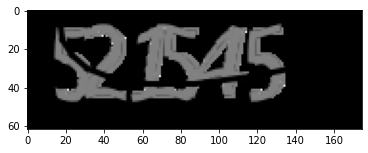

In [10]:
#Lets test an unknown captcha
#preview
%matplotlib inline 
import matplotlib.pyplot as plt
img=cv2.imread('data/test/wetax/521545.png',cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [11]:
#Lets Predict By Model
print("Predicted Captcha =",predict('data/test/wetax/521545.png', model))

Predicted Captcha = 525451


In [12]:
# 전체 모델을 HDF5 파일로 저장합니다
# '.h5' 확장자는 이 모델이 HDF5로 저장되었다는 것을 나타냅니다
model.save('model/wetax_captcha_model.h5')

In [13]:
# 가중치와 옵티마이저를 포함하여 정확히 동일한 모델을 다시 생성합니다
new_model = load_model('model/wetax_captcha_model.h5')

# 모델 구조를 출력합니다
new_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 62, 175, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 62, 175, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 31, 88, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 31, 88, 32)   4640        max_pooling2d[0][0]              
_______________________________________________________________________________________

In [14]:
score = new_model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4], y_test[5]], verbose=2)
print('='*100)
print('New Model Test Loss and accuracy:', score)

5/5 - 0s - loss: 16.8488 - dense_1_loss: 16.1123 - dense_3_loss: 6.5300e-07 - dense_5_loss: 0.1711 - dense_7_loss: 0.1493 - dense_9_loss: 0.2925 - dense_11_loss: 0.1236 - dense_1_accuracy: 0.0000e+00 - dense_3_accuracy: 1.0000 - dense_5_accuracy: 0.9851 - dense_7_accuracy: 0.9701 - dense_9_accuracy: 0.9627 - dense_11_accuracy: 0.9701
New Model Test Loss and accuracy: [16.84880256652832, 16.112314224243164, 6.529993470394402e-07, 0.171076700091362, 0.1492503434419632, 0.2925248146057129, 0.1236356794834137, 0.0, 1.0, 0.9850746393203735, 0.9701492786407471, 0.9626865386962891, 0.9701492786407471]


In [15]:
# Check model on some samples
model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4], y_test[5]])
print('='*100)
print(predict('data/test/wetax/028885.png', new_model))
print(predict('data/test/wetax/049858.png', new_model))
print(predict('data/test/wetax/339524.png', new_model))
print(predict('data/test/wetax/366405.png', new_model))
print(predict('data/test/wetax/400567.png', new_model))

5/5 [==============================] - 0s 10ms/step - loss: 16.8488 - dense_1_loss: 16.1123 - dense_3_loss: 6.5300e-07 - dense_5_loss: 0.1711 - dense_7_loss: 0.1493 - dense_9_loss: 0.2925 - dense_11_loss: 0.1236 - dense_1_accuracy: 0.0000e+00 - dense_3_accuracy: 1.0000 - dense_5_accuracy: 0.9851 - dense_7_accuracy: 0.9701 - dense_9_accuracy: 0.9627 - dense_11_accuracy: 0.9701   
026885
049838
339524
366405
400567
